In [14]:
# import all libraries
import nltk
nltk.download('punkt')         # only needed first time
nltk.download('stopwords')     # only needed first time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk import word_tokenize
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report
from copy import deepcopy
import joblib
from torch import nn, optim, no_grad, float, device, cuda, sum

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
# Define a custom dataset
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [16]:
# Define a simple neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [48]:
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    train_loss = 0.0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X.size(0)  # Accumulate the loss
    train_loss /= len(train_loader.dataset)  # Calculate the average loss
    return train_loss

def test(data_loader, model, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            output = model(X)
            loss = criterion(output, y)
            test_loss += loss.item() * X.size(0)  # Accumulate the loss
            _, predicted = torch.max(output, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)
    test_loss /= len(data_loader.dataset)  # Calculate the average loss
    accuracy = correct / total
    return test_loss, accuracy

In [49]:
def preprocess_pandas(data, columns):
    df_ = pd.DataFrame(columns=columns)
    data['Sentence'] = data['Sentence'].str.lower()
    data['Sentence'] = data['Sentence'].replace('[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+', '', regex=True)                      # remove emails
    data['Sentence'] = data['Sentence'].replace('((25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)(\.|$)){4}', '', regex=True)    # remove IP address
    data['Sentence'] = data['Sentence'].str.replace('[^\w\s]','')                                                       # remove special characters
    data['Sentence'] = data['Sentence'].replace('\d', '', regex=True)                                                   # remove numbers
    for index, row in data.iterrows():
        word_tokens = word_tokenize(row['Sentence'])
        filtered_sent = [w for w in word_tokens if not w in stopwords.words('english')]
        df_ = df_._append({
            "index": row['index'],
            "Class": row['Class'],
            "Sentence": " ".join(filtered_sent[0:])
        }, ignore_index=True)
    return data


In [50]:
# get data, pre-process and split
data = pd.read_csv("amazon_cells_labelled.txt", delimiter='\t', header=None)
data.columns = ['Sentence', 'Class']
data['index'] = data.index                                          # add new column index
columns = ['index', 'Class', 'Sentence']
data = preprocess_pandas(data, columns)                             # pre-process

training_data, validation_data, training_labels, validation_labels = train_test_split( # split the data into training, validation, and test splits
    data['Sentence'].values.astype('U'),
    data['Class'].values.astype('int32'),
    test_size=0.10,
    random_state=0,
    shuffle=True
)

test_data, validation_data, test_labels, validation_labels = train_test_split( # split the data into training, validation, and test splits
    validation_data,
    validation_labels,
    test_size=0.50,
    random_state=0,
    shuffle=True
)

# vectorize data using TFIDF and transform for PyTorch for scalability
word_vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,2), max_features=50000, max_df=0.5, use_idf=True, norm='l2')
training_data = word_vectorizer.fit_transform(training_data)        # transform texts to sparse matrix

# Save the vectorizer, to be used later by bot to tranform user input
joblib.dump(word_vectorizer, 'word_vectorizer.pkl')

training_data = training_data.todense()                             # convert to dense matrix for Pytorch
vocab_size = len(word_vectorizer.vocabulary_)
validation_data = word_vectorizer.transform(validation_data)
validation_data = validation_data.todense()
test_data = word_vectorizer.transform(test_data)
test_data = test_data.todense()
train_x_tensor = torch.from_numpy(np.array(training_data)).type(torch.FloatTensor)
train_y_tensor = torch.from_numpy(np.array(training_labels)).long()
validation_x_tensor = torch.from_numpy(np.array(validation_data)).type(torch.FloatTensor)
validation_y_tensor = torch.from_numpy(np.array(validation_labels)).long()
test_x_tensor = torch.from_numpy(np.array(test_data)).type(torch.FloatTensor)
test_y_tensor = torch.from_numpy(np.array(test_labels)).long()

# Create a dataset instance
train_dataset = MyDataset(train_x_tensor, train_y_tensor)
val_dataset = MyDataset(validation_x_tensor, validation_y_tensor)
test_dataset = MyDataset(test_x_tensor, test_y_tensor)

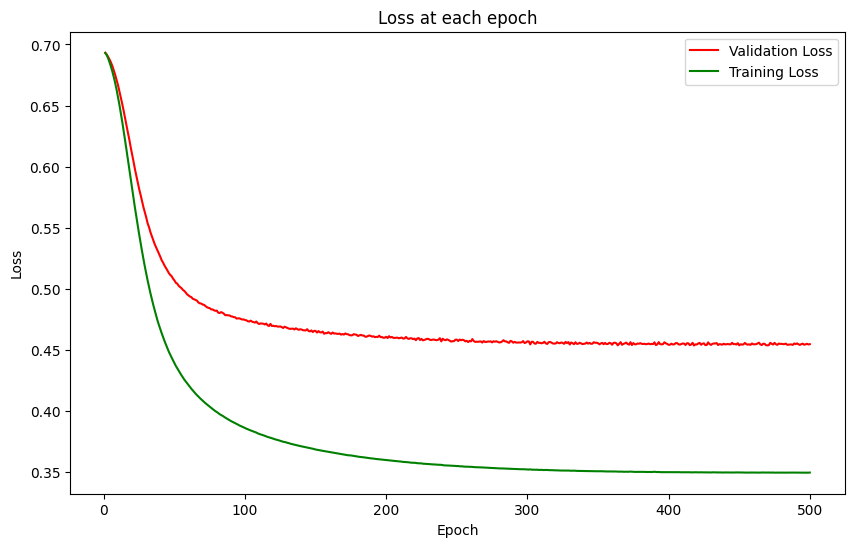

Test Accuracy: 88.00%
Done!


In [62]:
import matplotlib.pyplot as plt

# Hyperparams. Set these to reasonable values
BATCH_SIZE = 100
SHUFFLE = 2
LEARNING_RATE = 0.001
epochs = 500

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load data in the loader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Load our network
model = SimpleNN(vocab_size, 20, 2).to(device)

# Define our loss function
criterion = nn.CrossEntropyLoss()

# Define our optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.001)

train_losses = []
val_losses = []

# Train the model
for epoch in range(epochs):
    train_loss = train(train_loader, model, criterion, optimizer, device)
    val_loss, _ = test(val_loader, model, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Plotting the training and validation loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, epoch + 2), val_losses, color='red', linestyle='-', label='Validation Loss')
plt.plot(range(1, epoch + 2), train_losses, color='green', linestyle='-', label='Training Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss at each epoch')
plt.show()

# Evaluate the model on the test set
_,test_accuracy = test(test_loader, model, criterion, device)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

print("Done!")

### Bot that accepts user input, analyses it and responds to the user based on it analysis. Bot uses previously trained model for its analysis.

In [64]:
# Define a function to get a response for a given prompt
def get_response(inp,model):

    with torch.no_grad():
        output = model(inp)
        _, predicted = torch.max(output.data,1)
    #print(output)
    #print(predicted)

    if predicted == torch.tensor([0]):
        return 'Negative'
    else:
        return 'Positive'


# Function to pre-process input data
def preprocess_user_input(prompt):
    # get data, pre-process
    data = pd.DataFrame([[prompt, None]], columns=['Sentence', 'Class'])
    data['index'] = data.index                                          # add new column index
    columns = ['index', 'Class', 'Sentence']
    data = preprocess_pandas(data, columns)
    data['Sentence'].values.astype('U')


    # load and use the vectorizer for transforming the user input
    loaded_word_vectorizer = joblib.load('word_vectorizer.pkl')
    vocab_size = len(loaded_word_vectorizer.vocabulary_)
    inp_data = loaded_word_vectorizer.transform(data['Sentence']) # transform texts to sparse matrix
    inp_data = inp_data.todense()                             # convert to dense matrix for Pytorch
    inp_x_tensor = torch.from_numpy(np.array(inp_data)).type(torch.FloatTensor)

    return inp_x_tensor, vocab_size


# Main function to run the chatbot
def main():
    print("Bot: Hello! How are you feeling today? I will tell you if it is positive or negative.")

    while True:
        user_input = input("User: ")

        if user_input.lower() == 'exit':
            print("Bot: Goodbye!")
            break

        # Preprocess the input
        inp_x_tensor, vocab_size = preprocess_user_input(user_input)
        #print(inp_x_tensor)vs

        # Use the trained model to get the bot response. Bot responds with its analysis indicating wheter user input is positive or negative
        response = get_response(inp_x_tensor, model)
        print("Bot:", response)

if __name__ == "__main__":
    main()

Bot: Hello! How are you feeling today? I will tell you if it is positive or negative.
User: good
Bot: Positive
User: very good
Bot: Positive
User: bad
Bot: Negative
User: amazing
Bot: Positive
User: super
Bot: Positive
User: exit
Bot: Goodbye!
